Пример применения дерева калибровки вероятности для задачи классификации при высоком дисбалансе классов.

Посмотрим как дерево повышает точность прогноза и уменьшает ошибку калибровки вероятностей - ece (expected calibration error)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from tqdm.notebook import tqdm

Создаём данные для задачи. Задаём дикий дисбаланс классов.

In [20]:
X, y = datasets.make_classification(n_samples=10000, weights=[0.15])

Делим данные на три части.
Используя базовую модель (в данном случае это KNN) оцениваем точность и ошибку калибровки вероятностей на тестовом наборе данных.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.66)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, train_size=0.5)

In [22]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
accuracy = np.mean(clf.predict(X_test) == y_test)

print(f"accuracy = {accuracy}")

accuracy = 0.928235294117647


In [23]:
class ProbabilityCalibrationTree(object):
    def __init__(self, fitted_estimator):
        self.fitted_estimator = fitted_estimator
        self.path = None
        self.ccp_alphas = None
        self.impurities = None
        self.trees = []
    
    def fit(self, X_train, y_train, X_valid, y_valid, X_test, y_test):
        # переобучаем дерево - неограничивая его глубину и число наблюдений в листьях
        overfitted_tree = DecisionTreeClassifier()
        overfitted_tree.fit(X_train, y_train)
        
        # определяем всевозможные варианты стрижки
        self.path = overfitted_tree.cost_complexity_pruning_path(X_train, y_train)
        self.ccp_alphas, self.impurities = self.path.ccp_alphas, self.path.impurities
        
        # проходим по всем вариантам стриженных деревьев
        for ccp_alpha in tqdm(self.ccp_alphas):
            tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
            tree.fit(X_train, y_train)
            
            # пропускаем по дереву валидационную выборку для обучения логистической регрессии в листьях
            indexes = tree.tree_.apply(X_valid.astype(np.float32))
            nodes = np.unique(indexes)

            proba = self.fitted_estimator.predict_proba(X_valid)[:, 1].reshape(-1, 1)

            leaves_regressions = {}
            if_any_singular_leaf = False

            # обучаем логистическую регрессию в каждом листе
            for node in nodes:
                # контролируем чтобы в листьях были оба класса
                if len(np.unique(y_valid[indexes==node])) == 1: 
                    if_any_singular_leaf = True
                    break
                
                # калибруем данные в листе логистической регрессией
                leaf_regression = LogisticRegression()
                leaf_regression.fit(proba[indexes==node], y_valid[indexes==node])
                leaves_regressions[node] = leaf_regression

            # если хотябы в одном листе дерева не оба класса, дерево пропускаем
            if if_any_singular_leaf: 
                continue
            
            # иначе сохраняем дерево, его характеристики и результаты калибровки тестового набора
            tree_parameters = {"tree": tree,
                               "leaves_regressions": leaves_regressions,
                               "nodes": nodes,
                               "ccp_alpha": ccp_alpha,
                               "tree_depth": tree.get_depth()}
            
            # результаты калибровки тестового набора, откалиброванная точность, ошибка и доли 1 класса для 
            # построения графика reliability
            data = self.calibrate(tree_parameters, X_test, y_test)
            tree_parameters["ece"] = data[0]
            tree_parameters["p_bins"] = data[1]
            tree_parameters["y_bins"] = data[2]
            tree_parameters["accuracy"] = data[3]
            self.trees.append(tree_parameters)
        return None

    def calibrate(self, tree_parameters, X_test, y_test):
        # пропускаем через откалиброванное дерево тестовые данные и возвращаем результаты калибовки
        indexes = tree_parameters["tree"].tree_.apply(X_test.astype(np.float32))
        nodes = np.unique(indexes)
        proba = self.fitted_estimator.predict_proba(X_test)[:, 1].reshape(-1, 1)

        calibrated = np.zeros_like(proba)
        regressions = tree_parameters["leaves_regressions"]

        for node in tree_parameters["nodes"]:
            calibrated[indexes==node] = regressions[node].predict_proba(proba[indexes==node])[:, 1].reshape(-1, 1)
        
        accuracy = np.mean(np.where(calibrated.reshape(-1) < 0.5, 0, 1) == y_test)
        ece, p_bins, y_bins = ProbabilityCalibrationTree.evaluate_ece(calibrated.reshape(-1), y_test)
        return (ece, p_bins, y_bins, accuracy)
    
    @staticmethod
    def evaluate_ece(calibrated, y_test, n_bins=20):
        # метод ля оценки ошибки - expected calibration error и расчёта долей 1 класса
        ece = 0
        index = np.argsort(calibrated)
        p_bins = []
        y_bins = []
        amount = []

        step = int(len(y_test) / n_bins)

        for i in range(n_bins):
            start = i * step
            end   = (i + 1) * step

            p_bins.append(np.mean(calibrated[index[start: end]]))
            y_bins.append(np.mean(y_test[index[start: end]]))
            amount.append(step)

            ece += amount[i] * (np.abs(np.array(p_bins[i]) - np.array(y_bins[i])))
        
        ece /= len(y_test)
        return ece, p_bins, y_bins
    
    @staticmethod
    def plot_reliability(p_bins, y_bins, title):
        # метод для построения диаграммы reliability
        plt.figure(figsize=(3, 3))
        plt.title(title)
        plt.plot(p_bins, y_bins, "o")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("predicted 1st class proba")
        plt.ylabel("actual 1st class ratio")
#         plt.savefig("reliability.png", transparent=False, bbox_inches="tight") 
        plt.show()

In [24]:
proba = clf.predict_proba(X_test)[:, 1]

ece, p_bins, y_bins = ProbabilityCalibrationTree.evaluate_ece(proba, y_test)

Итак. Ошибка калибровки (ece), точность базовой модели (accuracy) и диаграмма reliability (достоверности) для базовой модели.

KNeighborsClassifier()


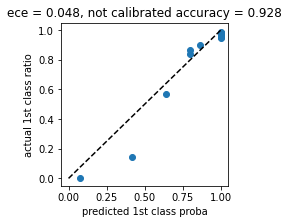

In [25]:
print(clf)
title = f"ece = {round(ece, 3)}, not calibrated accuracy = {round(accuracy, 3)}"
ProbabilityCalibrationTree.plot_reliability(p_bins, y_bins, title)

Далее калибруем вероятности, используя дерево. Дерево изначально переобучаем (не используем регулиризацию - глубину и т.п.) на тренировочном наборе. Определяем всевозможные пути стрижки дерева (параметр - ccp_alpha). Для каждого варианта стрижки калибруем валидационный набор в листьях логистической регрессией.

Используем все три набора данных.

In [ ]:
pct = ProbabilityCalibrationTree(clf)
pct.fit(X_train, y_train, X_valid, y_valid, X_test, y_test)

  0%|          | 0/35 [00:00<?, ?it/s]

Делаем контроль на данных, которые дерево не видело.

In [ ]:
eces = []
scores = []

for item in pct.trees:
    eces.append(str(round(item["ece"], 3)))
    scores.append(round(item["accuracy"], 3))
    
    ccp_alpha = str(round(item["ccp_alpha"], 4))
    
    title = f"ece = {eces[-1]}, calibrated accuracy = {scores[-1]}, ccp_alpha = {ccp_alpha}"
    ProbabilityCalibrationTree.plot_reliability(item["p_bins"], item["y_bins"], title)

Ошибка калибровки меньше, точность прогноза выше по сравнению с базовой моделью. Здорово! Плохо лишь то, что данные пришлось делить на три части.

In [ ]:
print(f"minimal ece = {min(eces)}, maximum accuracy = {max(scores)}")

Но, оказывается, деревья калибровки также можно переобучить. Для этого логистическую регрессию в узлах тоже обучаем на тренировочном наборе данных.

In [ ]:
pct = ProbabilityCalibrationTree(clf)
pct.fit(X_train, y_train, X_train, y_train, X_test, y_test)

Делаем контроль на данных, которые дерево не видело.

In [ ]:
eces = []
scores = []

for item in pct.trees:
    eces.append(str(round(item["ece"], 3)))
    scores.append(round(item["accuracy"], 3))
    
    ccp_alpha = str(round(item["ccp_alpha"], 4))
    
    title = f"ece = {eces[-1]}, calibrated accuracy = {scores[-1]}, ccp_alpha = {ccp_alpha}"
    ProbabilityCalibrationTree.plot_reliability(item["p_bins"], item["y_bins"], title)

Результаты тоже неплохие. Т.е. данные можно делить на два набора а не на три!!!

In [ ]:
print(f"minimal ece = {min(eces)}, maximum accuracy = {max(scores)}")

Конец